In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D

from skimage.morphology import disk, dilation
from skimage.measure import regionprops

np.random.seed(6)
lbl_cmap = random_label_cmap()

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# Predict with GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [28]:
import os
base_path = 'Z:/Data/Analyzed/2024-03-12-Mingrui-PFC/images/stardist_sample'
data_path = os.path.join(base_path, 'hard')
output_path = os.path.join(base_path, 'output')

In [29]:
X = sorted(glob(data_path + '/*.tif'))
# X = sorted(glob('../test/images/*.tif'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

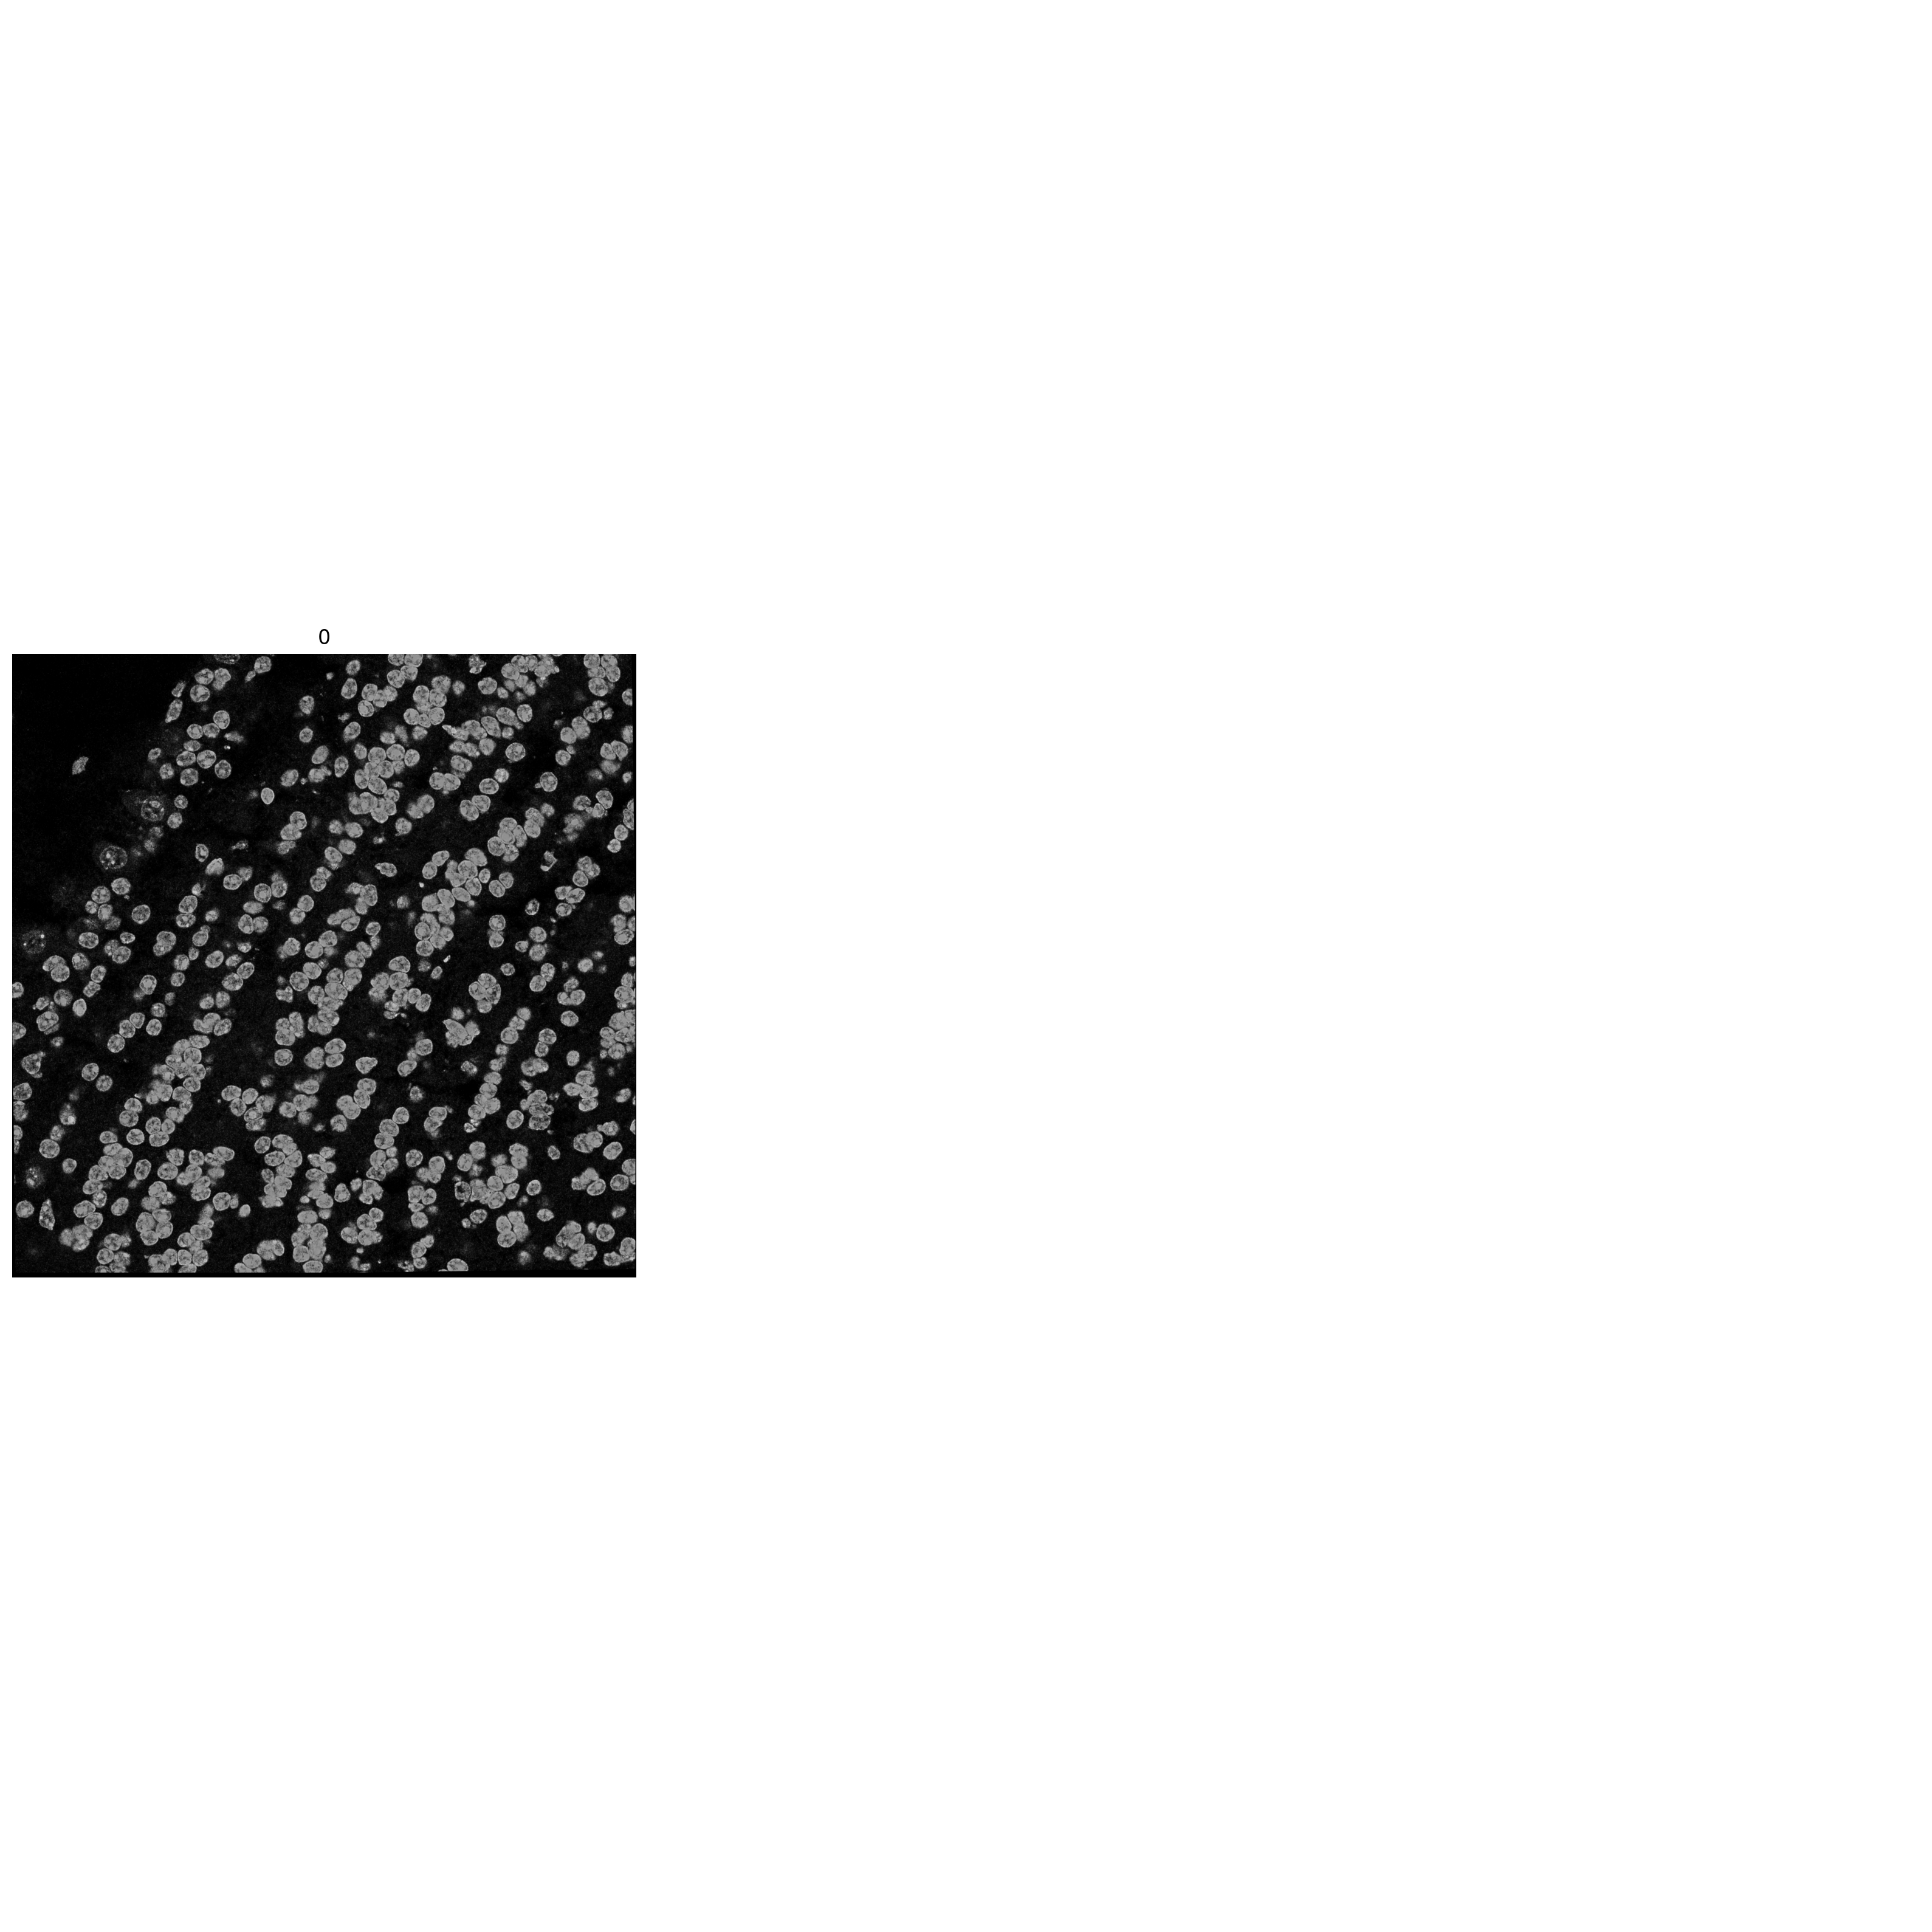

In [30]:
# show all test images
if True:
    fig, ax = plt.subplots(1,3, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x[x.shape[0]//2],cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [8]:
model = StarDist3D(None, name='3D_brain_resnet', basedir='models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.679983, nms_thresh=0.3.


In [9]:
model

StarDist3D(3D_brain_resnet): ZYXC → ZYXC
├─ Directory: \\iron\stanley_WangLab\jiahao\Github\starfinder\test\Mingrui\stardist\models\3D_brain_resnet
└─ Config3D(n_dim=3, axes='ZYXC', n_channel_in=1, n_channel_out=97, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=96, grid=(1, 8, 8), anisotropy=(3.4864864864864864, 1.0, 1.075), backbone='resnet', rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 96, 'anisotropy': (3.4864864864864864, 1.0, 1.075)}}, n_classes=None, resnet_n_blocks=4, resnet_kernel_size=[3, 3, 3], resnet_kernel_init='he_normal', resnet_n_filter_base=32, resnet_n_conv_per_block=3, resnet_activation='relu', resnet_batch_norm=False, net_conv_after_resnet=128, net_input_shape=[None, None, None, 1], net_mask_shape=[None, None, None, 1], train_patch_size=[32, 128, 128], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0

## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [10]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

session.py (1769): An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).


In [31]:
%%time

img = normalize(X[0], 1, 99.8, axis=axis_norm)
labels, details = model.predict_instances(img, prob_thresh=0.5, nms_thresh=0.1, n_tiles=[1, 8, 8])

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:33<00:00,  1.91it/s]


CPU times: total: 2h 9min 14s
Wall time: 6min 32s


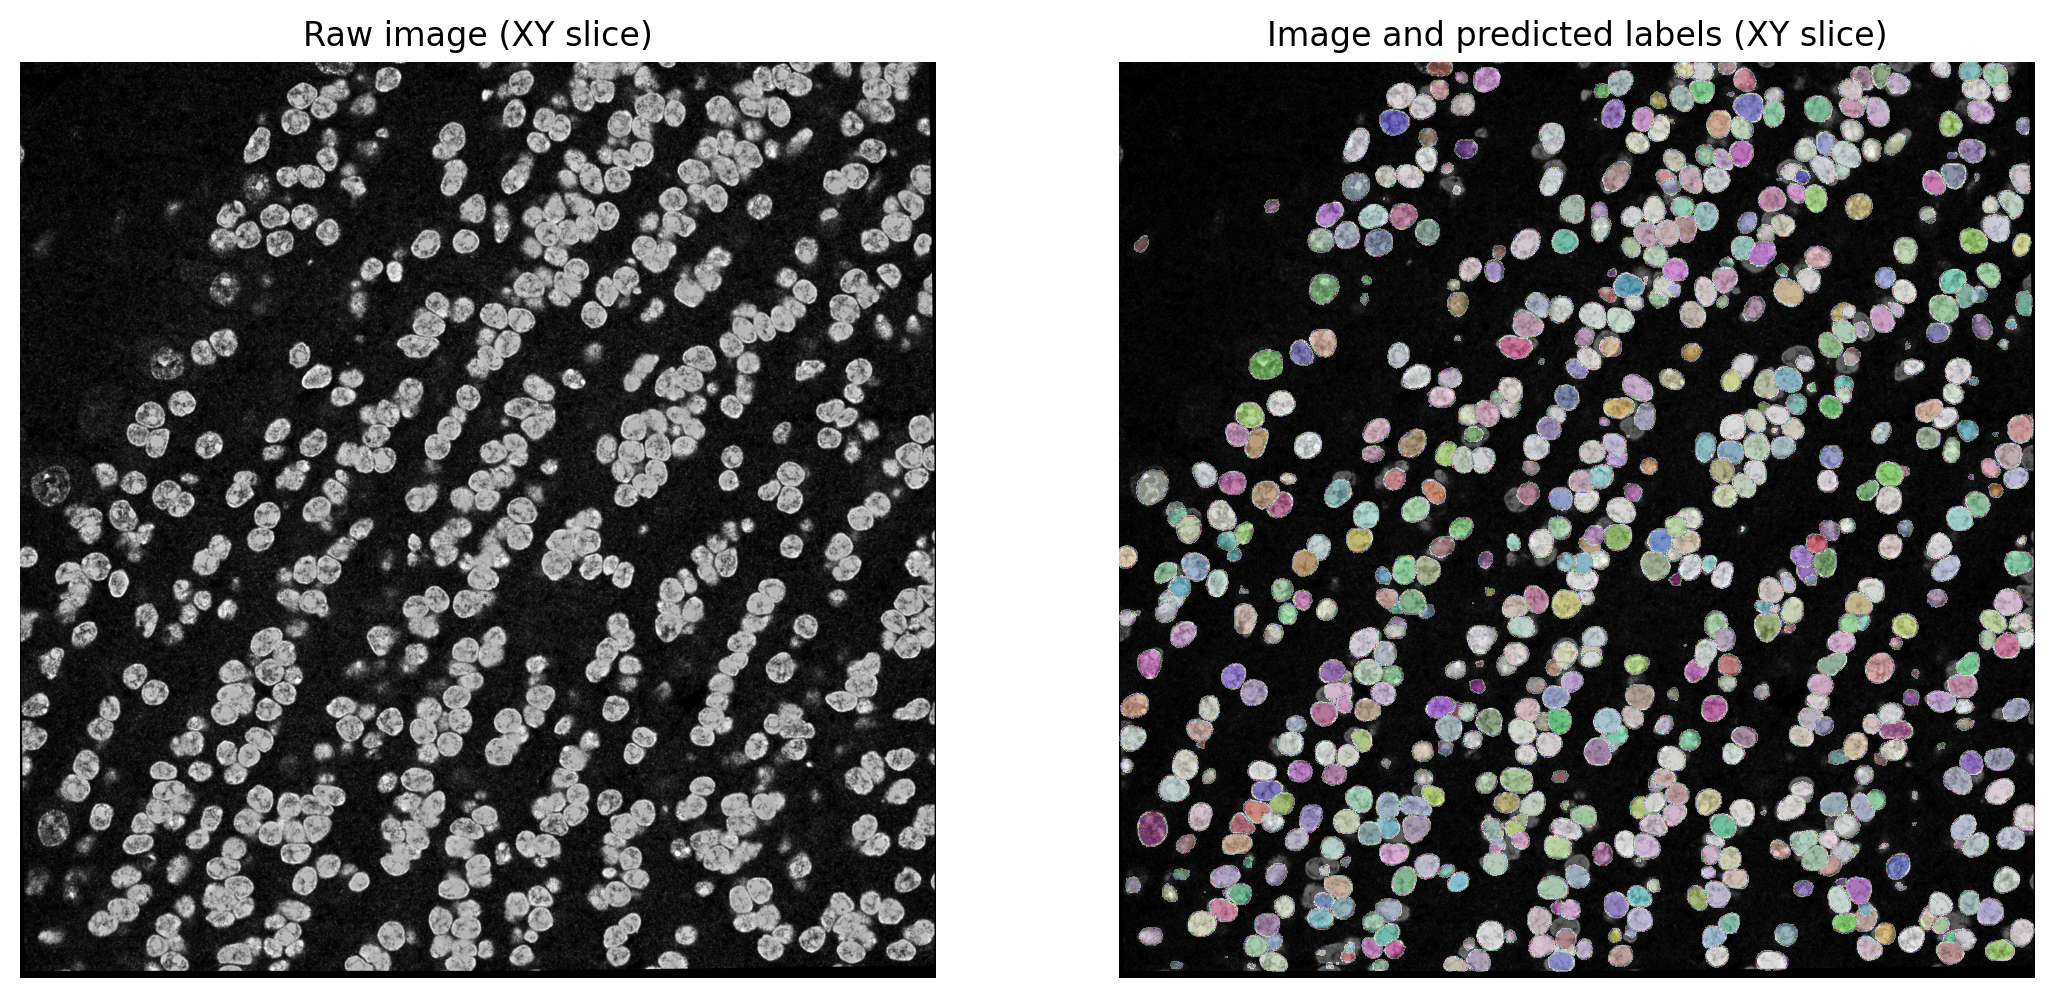

In [32]:
plt.figure(figsize=(13,10))
z = max(0, img.shape[0] // 2 - 5)
plt.subplot(121)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.title('Raw image (XY slice)')
plt.axis('off')
plt.subplot(122)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
plt.title('Image and predicted labels (XY slice)')
plt.axis('off');

## Save predictions

Uncomment the lines in the following cell if you want to save the example image and the predicted label image to disk.

In [33]:
save_tiff_imagej_compatible(os.path.join(output_path, 'example_image_resnet_1.tif'), img, axes='ZYX')
save_tiff_imagej_compatible(os.path.join(output_path, 'example_labels_resnet_1.tif'), labels, axes='ZYX')

# Example results

In [ ]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,8))
    z = img.shape[0] // 2
    y = img.shape[1] // 2
    img_show = img if img.ndim==3 else img[...,:3]    
    plt.subplot(221); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.subplot(222); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.subplot(223); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
    plt.subplot(224); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.imshow(labels[:,y], cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
example(model, 0)

In [ ]:
example(model, 1)

In [ ]:
example(model, 2)

## Hard Prediction

In [38]:
hard_X = sorted(glob('../hard/images/*.tif'))
hard_X = list(map(imread,hard_X))

n_channel = 1 if hard_X[0].ndim == 3 else hard_X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently

In [39]:
len(hard_X)

12

In [40]:
hard_X[3].shape

(37, 2132, 4156)

In [41]:
%%time
img = normalize(hard_X[3], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img, n_tiles=[1, 4, 8], prob_thresh=0.25, nms_thresh=0.1)

se = disk(3, dtype=np.int32)

for z in range(labels.shape[0]):
    curr_slice = labels[z,:,:]
    labels[z,:,:] = dilation(curr_slice, se)


save_tiff_imagej_compatible('hard_12_mask.tif', labels, axes='ZYX')

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:44<00:00,  1.39s/it]


Wall time: 3min 8s


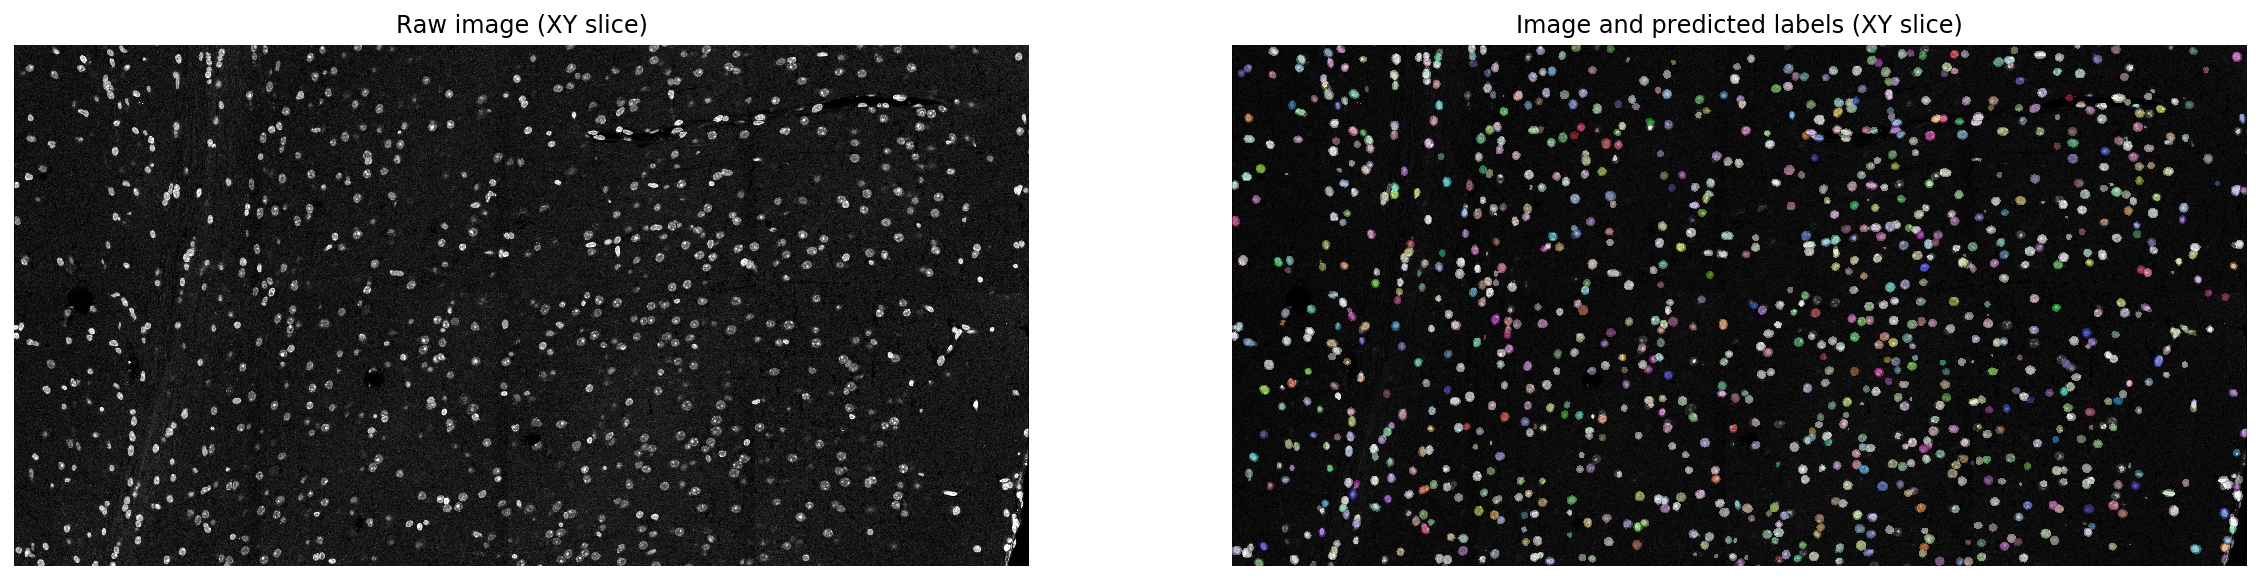

In [42]:

plt.figure(figsize=(20,10))
z = max(0, img.shape[0] // 2 - 5)
plt.subplot(121)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.title('Raw image (XY slice)')
plt.axis('off')
plt.subplot(122)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
plt.title('Image and predicted labels (XY slice)')
plt.axis('off');

## Batch prediction

In [71]:
%%time

prob_thresh = 0.2
nms_thresh = 0.5 
base_path = "E:/Cardiac_0701/round1"
output_path = "E:/Cardiac_0701/output/stardist_3d_2"

if not os.path.exists(output_path):
    os.mkdir(output_path)
    
dirs = os.listdir(base_path)

se = disk(4, dtype=np.int32)

with open(os.path.join(output_path, "log.txt"), "w") as f:
    
    for folder in dirs:
        position_folder = os.path.join(base_path, folder)
        curr_dapi = glob(f'{position_folder}/*.tif')[-1]
        curr_dapi = imread(curr_dapi)

        curr_dapi = normalize(curr_dapi, 1, 99.8, axis=axis_norm)
        labels, details = model.predict_instances(curr_dapi, n_tiles=[1, 1, 4], prob_thresh=prob_thresh, nms_thresh=nms_thresh)

        for z in range(labels.shape[0]):
            curr_slice = labels[z,:,:]
            labels[z,:,:] = dilation(curr_slice, se)

        curr_output = os.path.join(output_path, f"{folder}.tif")
        save_tiff_imagej_compatible(curr_output, labels, axes='ZYX')
        ncells = np.unique(labels).shape[0] - 1
        f.write(f"{folder}: {ncells}\n")
        
    f.write(f"prob_threshold: {prob_thresh}\nnms_threshold: {nms_thresh}")


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Wall time: 3h 16min 43s
